In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import random 

import yfinance as yf
from yahooquery import Ticker
from yahooquery import Screener

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional, Dropout
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

from utils import *

C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024


# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [4]:
spy_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'spy_ohlc_df.csv')
dow_jones_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'dow_jones_ohlc_df.csv')
nasdaq_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'nasdaq_ohlc_df.csv')

In [5]:
df_rnn_spy = make_df_from(spy_ohlc_df)
df_rnn_dow = make_df_from(dow_jones_ohlc_df)

In [6]:
df_rnn = nasdaq_ohlc_df[['Date', 'Close']].copy()
df_rnn['Date'] = pd.to_datetime(df_rnn['Date'])
df_rnn.set_index('Date', inplace=True)
df_rnn.head()

,Close
Date,
1995-01-03,398.000000
1995-01-04,399.649994
1995-01-05,398.019989
1995-01-06,401.589996
1995-01-09,403.529999


In [7]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
                           
def create_model1(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(64, return_sequences = True, input_shape= [None,1]))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(128, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(64, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(32))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [8]:
nq = yf.download(tickers = "^IXIC",  
                    start='2017-01-01', 
                    end='2023-01-01')

dji = yf.download(tickers = "^DJI",  
                    start='2017-01-01', 
                    end='2023-01-01')

spx = yf.download(tickers = "^SPX",  
                    start='2017-01-01', 
                    end='2023-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
merged_df_dict = {'Date': np.array(nasdaq_ohlc_df[(nasdaq_ohlc_df['Date'] > "2017-01-01") & (nasdaq_ohlc_df['Date'] < "2023-01-01")]['Date'].values), 
             'IXIC': np.array(nq.Close.values), 
             'SPX': np.array(spx.Close.values), 
             'DJI': np.array(dji.Close.values)}

merged_df_index = nasdaq_ohlc_df[(nasdaq_ohlc_df['Date'] > "2017-01-01") & (nasdaq_ohlc_df['Date'] < "2023-01-01")].reset_index(drop=True).index

merged_df = pd.DataFrame(data=merged_df_dict, index=merged_df_index, columns=['Date', 'IXIC', 'SPX', 'DJI'])

In [10]:
merged_df.head()

,Date,IXIC,SPX,DJI
0,2017-01-03,5429.080078,2257.830078,19881.759766
1,2017-01-04,5477.000000,2270.750000,19942.160156
2,2017-01-05,5487.939941,2269.000000,19899.289062
3,2017-01-06,5521.060059,2276.979980,19963.800781
4,2017-01-09,5531.819824,2268.899902,19887.380859


In [11]:
df = merged_df[['Date', 'IXIC']].copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,IXIC
Date,
2017-01-03,5429.080078
2017-01-04,5477.000000
2017-01-05,5487.939941
2017-01-06,5521.060059
2017-01-09,5531.819824


In [12]:
rnn_predictions_n_errors = pd.DataFrame(
                                        data=None,
                                        index=None,
                                        columns=['1_day', '5_days', '10_days', '1_month', '2_months', '6_months', '1_year']
                                        )

rnn_predictions_n_errors['Dataset'] = ['IXIC', 'IXIC', 'IXIC', 'DJI', 'DJI', 'DJI', 'SPX', 'SPX', 'SPX']
rnn_predictions_n_errors['Metric'] = ['RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE']

rnn_predictions_n_errors.set_index(['Dataset', 'Metric'], inplace=True)

In [13]:
set(rnn_predictions_n_errors.index.get_level_values(0))

{'DJI', 'IXIC', 'SPX'}

In [14]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [15]:
df

array([[0.        ],
       [0.00450868],
       [0.005538  ],
       ...,
       [0.45013622],
       [0.47505068],
       [0.47395837]])

In [16]:
# for dataset in set(rnn_predictions_n_errors.index.get_level_values(0)):

#   df = merged_df[['Date', dataset]].copy()
#   df['Date'] = pd.to_datetime(df['Date'])
#   df.set_index('Date', inplace=True)
#   # df.head()

#   scaler = MinMaxScaler()
#   df = scaler.fit_transform(df)

#   for pred_horizon, horizon_string in [[1, '1_day'], [5, '5_days'], [10, '10_days'], [30, '1_month']]:

#     rnn_predictions_n_errors = assign_values(rnn_predictions_n_errors,
#                                           dataset,
#                                           [0],
#                                           [pred_horizon], 
#                                           horizon_string)
  
# rnn_predictions_n_errors

In [17]:
# rnn_predictions_n_errors.to_csv("rnn_errors.csv")

In [18]:
# pd.read_csv("rnn_errors.csv")

In [19]:
def rnn_pipe(lookback_horizon, save_dir, model_str, rnn_predictions_n_errors):

  for dataset in set(rnn_predictions_n_errors.index.get_level_values(0)):

    df = merged_df[['Date', dataset]].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    # df.head()

    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)

    for pred_horizon, horizon_string in [[1, '1_day'], [5, '5_days'], [10, '10_days'], [30, '1_month']]:
      # use 50 historical observations, predict 1 step ahead
      look_back = lookback_horizon
      look_ahead = pred_horizon

      xdat, ydat = create_dataset(df, 
                                  look_back = look_back, 
                                  look_ahead = look_ahead
                                  )

      # We only want to forecast a single value for each series => target is a column
      xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = int(len(xdat) * 0.8), timesteps = look_back)

      model1 = create_model1(look_ahead)
      # model1.summary()
      print(dataset, pred_horizon, horizon_string)
      
      history=model1.fit(xtrain, 
                ytrain, 
                validation_data=(xvalid, yvalid), 
                epochs = 20, 
                batch_size = 32, 
                callbacks=[ early_stop]
                )

      y_pred = model1.predict(xvalid)
      y_pred = scaler.inverse_transform(y_pred)
      yvalid = scaler.inverse_transform(yvalid)

      plt.plot([item[0] for item in yvalid], label="True")
      # plt.plot([item.mean() for item in y_pred], label="Forecast")
      plt.plot([item[0] for item in y_pred], label="Forecast")
      plt.legend()
      plt.savefig(f"{CFG.data_path}/{save_dir}/{model_str}/{model_str}_{dataset}_{horizon_string}.jpg", bbox_inches='tight', dpi=120)
      plt.clf()
      # predict and calculate RMSE
      rnn_predictions_n_errors = assign_values(rnn_predictions_n_errors,
                                              dataset,
                                              y_pred,
                                              yvalid, 
                                              horizon_string)

  rnn_predictions_n_errors.to_csv(f"{CFG.data_path}/{save_dir}/{model_str}/{model_str}_{save_dir}_window_errors.csv")

In [21]:
rnn_pipe(20, '20d', 'rnn', rnn_predictions_n_errors)

SPX 1 1_day
Epoch 1/20
38/38 [==============================] - 7s 54ms/step - loss: 0.5572 - val_loss: 0.2030
Epoch 2/20
38/38 [==============================] - 1s 30ms/step - loss: 0.1614 - val_loss: 0.1028
Epoch 3/20
38/38 [==============================] - 1s 26ms/step - loss: 0.0697 - val_loss: 0.0182
Epoch 4/20
38/38 [==============================] - 1s 19ms/step - loss: 0.0441 - val_loss: 0.0043
Epoch 5/20
38/38 [==============================] - 1s 19ms/step - loss: 0.0327 - val_loss: 0.0035
Epoch 6/20
38/38 [==============================] - 1s 19ms/step - loss: 0.0272 - val_loss: 0.0057
Epoch 7/20
38/38 [==============================] - 1s 26ms/step - loss: 0.0203 - val_loss: 0.0164
Epoch 8/20
38/38 [==============================] - 1s 26ms/step - loss: 0.0174 - val_loss: 0.0058
Epoch 9/20
38/38 [==============================] - 1s 26ms/step - loss: 0.0155 - val_loss: 0.0063
Epoch 9: early stopping
10/10 [==============================] - 1s 7ms/step
SPX 5 5_days
Epoch 1

<Figure size 1440x720 with 0 Axes>

In [22]:
rnn_pipe(50, '50d', 'rnn', rnn_predictions_n_errors)

SPX 1 1_day
Epoch 1/20
37/37 [==============================] - 9s 76ms/step - loss: 0.4960 - val_loss: 0.1567
Epoch 2/20
37/37 [==============================] - 2s 66ms/step - loss: 0.1645 - val_loss: 0.0333
Epoch 3/20
37/37 [==============================] - 2s 60ms/step - loss: 0.0794 - val_loss: 0.0617
Epoch 4/20
37/37 [==============================] - 2s 64ms/step - loss: 0.0512 - val_loss: 0.0607
Epoch 5/20
37/37 [==============================] - 2s 61ms/step - loss: 0.0367 - val_loss: 0.0366
Epoch 6/20
37/37 [==============================] - 2s 59ms/step - loss: 0.0270 - val_loss: 0.0266
Epoch 7/20
37/37 [==============================] - 2s 49ms/step - loss: 0.0227 - val_loss: 0.0198
Epoch 8/20
37/37 [==============================] - 2s 50ms/step - loss: 0.0195 - val_loss: 0.0142
Epoch 9/20
37/37 [==============================] - 2s 49ms/step - loss: 0.0173 - val_loss: 0.0126
Epoch 10/20
37/37 [==============================] - 2s 57ms/step - loss: 0.0156 - val_loss: 0.01

<Figure size 1440x720 with 0 Axes>

In [23]:
rnn_pipe(80, '80d', 'rnn', rnn_predictions_n_errors)

SPX 1 1_day
Epoch 1/20
36/36 [==============================] - 10s 124ms/step - loss: 0.4436 - val_loss: 0.0453
Epoch 2/20
36/36 [==============================] - 4s 103ms/step - loss: 0.1272 - val_loss: 0.0123
Epoch 3/20
36/36 [==============================] - 4s 100ms/step - loss: 0.0797 - val_loss: 0.0594
Epoch 4/20
36/36 [==============================] - 4s 101ms/step - loss: 0.0542 - val_loss: 0.0054
Epoch 5/20
36/36 [==============================] - 4s 117ms/step - loss: 0.0437 - val_loss: 0.0145
Epoch 6/20
36/36 [==============================] - 4s 105ms/step - loss: 0.0297 - val_loss: 0.0077
Epoch 7/20
36/36 [==============================] - 4s 112ms/step - loss: 0.0273 - val_loss: 0.0086
Epoch 8/20
36/36 [==============================] - 4s 103ms/step - loss: 0.0226 - val_loss: 0.0062
Epoch 9/20
36/36 [==============================] - 4s 102ms/step - loss: 0.0174 - val_loss: 0.0068
Epoch 9: early stopping
9/9 [==============================] - 1s 23ms/step
SPX 5 5_day

<Figure size 1440x720 with 0 Axes>

In [24]:
df

array([[0.        ],
       [0.00450868],
       [0.005538  ],
       ...,
       [0.45013622],
       [0.47505068],
       [0.47395837]])

In [24]:
pd.read_csv("../data/rnn_errors.csv")

,Dataset,Metric,1_day,5_days,10_days,1_month,2_months,6_months,1_year
0,IXIC,RMSE,955.4707,1191.1360,1170.6248,1204.2181,NaN,NaN,NaN
1,IXIC,MAE,746.3889,987.2992,953.0504,1015.5199,NaN,NaN,NaN
2,IXIC,MAPE,0.0578,0.0763,0.0770,0.0819,NaN,NaN,NaN
3,DJI,RMSE,1475.5896,1675.4561,4977.2574,5483.5528,NaN,NaN,NaN
4,DJI,MAE,1171.0329,1371.3411,4199.5432,4613.3003,NaN,NaN,NaN
5,DJI,MAPE,0.0376,0.0412,0.1496,0.1684,NaN,NaN,NaN
6,SPX,RMSE,166.1944,304.7239,341.9458,307.8926,NaN,NaN,NaN
7,SPX,MAE,138.2133,260.3289,281.6447,258.8493,NaN,NaN,NaN
8,SPX,MAPE,0.0328,0.0611,0.0689,0.0619,NaN,NaN,NaN


In [21]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, 
                            look_back = look_back, 
                            look_ahead = look_ahead
                            )

# We only want to forecast a single value for each series => target is a column
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = int(len(xdat) * 0.8), timesteps = look_back)

model1 = create_model1(look_ahead)
# model1.summary()

model1.fit(xtrain, 
          ytrain, 
          validation_data=(xvalid, yvalid), 
          epochs = 20, 
          batch_size = 32, 
          callbacks=[ early_stop]
          )

y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)

Epoch 1/20
37/37 [==============================] - 10s 99ms/step - loss: 0.5630 - val_loss: 0.1426
Epoch 2/20
37/37 [==============================] - 2s 55ms/step - loss: 0.1678 - val_loss: 0.0405
Epoch 3/20
37/37 [==============================] - 2s 63ms/step - loss: 0.1041 - val_loss: 0.0206
Epoch 4/20
37/37 [==============================] - 2s 60ms/step - loss: 0.0763 - val_loss: 0.0781
Epoch 5/20
37/37 [==============================] - 3s 73ms/step - loss: 0.0631 - val_loss: 0.0044
Epoch 6/20
37/37 [==============================] - 3s 95ms/step - loss: 0.0436 - val_loss: 0.0128
Epoch 7/20
37/37 [==============================] - 3s 85ms/step - loss: 0.0351 - val_loss: 0.0401
Epoch 8/20
37/37 [==============================] - 3s 70ms/step - loss: 0.0288 - val_loss: 0.0254
Epoch 9/20
37/37 [==============================] - 4s 112ms/step - loss: 0.0265 - val_loss: 0.0190
Epoch 10/20
37/37 [==============================] - 3s 86ms/step - loss: 0.0199 - val_loss: 0.0201
Epoch 1

In [22]:
# predict and calculate RMSE
rnn_predictions_n_errors = assign_values(rnn_predictions_n_errors,
                                          'SPX',
                                          y_pred1,
                                          scaler.inverse_transform(yvalid), 
                                          '1_day')

RMSE LSTM: 169.6373
MAE LSTM: 140.2644
MAPE LSTM: 3.47%


In [16]:
y_pred1

NameError: name 'y_pred1' is not defined

In [23]:
rnn_predictions_n_errors.to_csv("rnn_errors.csv")

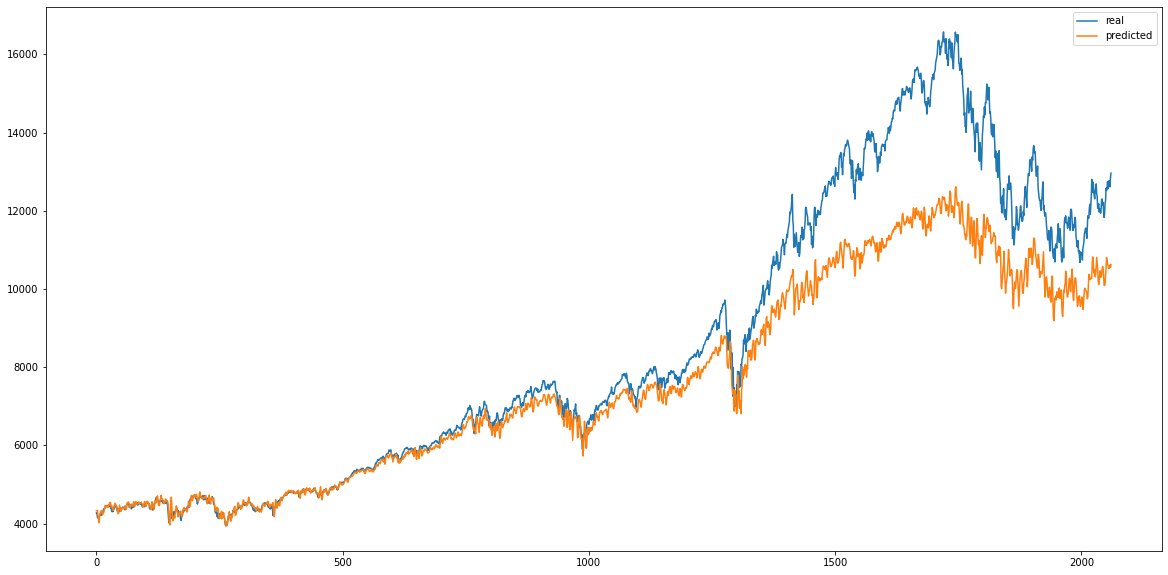

In [30]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

More layers

In [18]:
def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [19]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

Epoch 1/6
313/313 [==============================] - 9s 20ms/step - loss: 6.4988e-04 - val_loss: 0.0405
Epoch 2/6
313/313 [==============================] - 7s 23ms/step - loss: 7.6567e-05 - val_loss: 0.0209
Epoch 3/6
313/313 [==============================] - 11s 34ms/step - loss: 4.6273e-05 - val_loss: 0.0153
Epoch 4/6
313/313 [==============================] - 10s 31ms/step - loss: 4.0281e-05 - val_loss: 0.0142
Epoch 5/6
313/313 [==============================] - 9s 30ms/step - loss: 4.1070e-05 - val_loss: 0.0114
Epoch 6/6
313/313 [==============================] - 8s 27ms/step - loss: 3.2721e-05 - val_loss: 0.0093


In [31]:
y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)

65/65 [==============================] - 0s 5ms/step


In [32]:
rmse_model2 = my_rmse(y_pred2, scaler.inverse_transform(yvalid))
print('RMSE: ' + str(rmse_model2))

RMSE: 1562.9196


Looking more into future

In [33]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df_rnn, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

In [34]:
def create_model3(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model3 = create_model3(out_dim = look_ahead)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


In [35]:
model3.fit(xtrain, ytrain, 
          validation_data=(xvalid, yvalid), 
          epochs = CFG.nepochs, 
          batch_size = CFG.bsize, 
          callbacks=[ early_stop])

Epoch 1/6
313/313 [==============================] - 9s 18ms/step - loss: 0.0023 - val_loss: 0.1754
Epoch 2/6
313/313 [==============================] - 8s 26ms/step - loss: 2.9930e-04 - val_loss: 0.0823
Epoch 3/6
313/313 [==============================] - 7s 24ms/step - loss: 1.4507e-04 - val_loss: 0.0588
Epoch 4/6
313/313 [==============================] - 9s 28ms/step - loss: 1.0099e-04 - val_loss: 0.0445
Epoch 5/6
313/313 [==============================] - 7s 22ms/step - loss: 7.5482e-05 - val_loss: 0.0355
Epoch 6/6
313/313 [==============================] - 7s 21ms/step - loss: 5.9234e-05 - val_loss: 0.0323


In [36]:
# predict and calculate RMSE
y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)

65/65 [==============================] - 1s 6ms/step


In [37]:
print('RMSE: ' + str(my_rmse(y_pred3, scaler.inverse_transform(yvalid))))

RMSE: 2907.4048


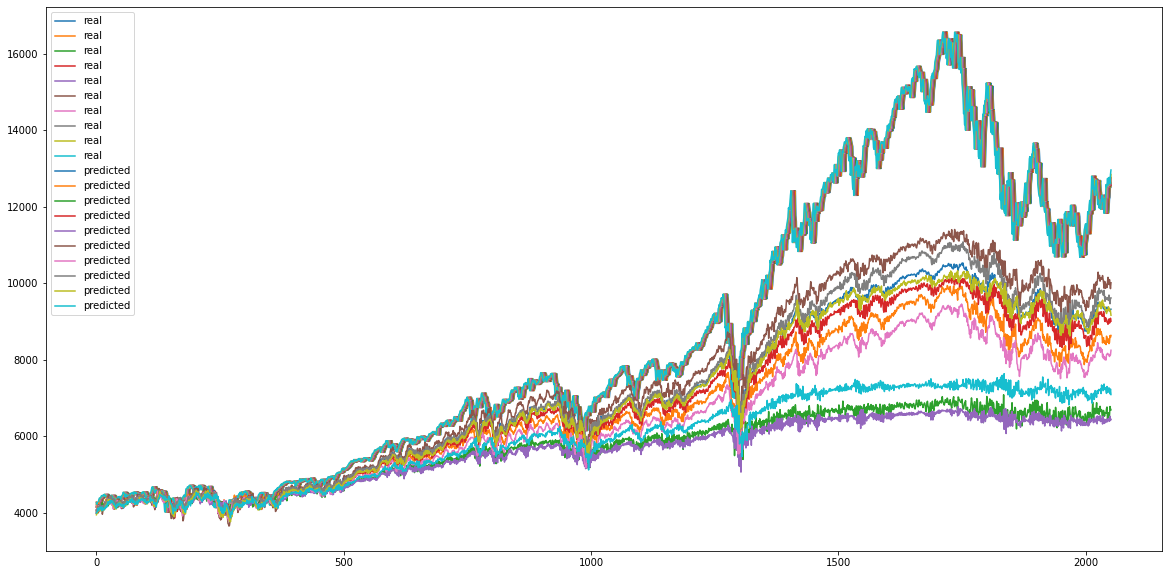

In [39]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real')
plt.plot(y_pred3, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [41]:
df_rnn

array([[0.00000000e+00],
       [1.02006753e-04],
       [1.23577086e-06],
       ...,
       [7.69568392e-01],
       [7.76808387e-01],
       [7.90298673e-01]])